In [1]:
import altair as alt
import numpy as np
import pandas as pd
import seaborn as sns
from foodwebs.foodweb import FoodWeb
from foodwebs.foodweb_io import readFW_SCOR
import networkx as nx

import matplotlib.pyplot as pltś
import pylab

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [2]:
import glob
food_webs = [readFW_SCOR(net_path) for net_path in glob.glob('./data/*')]

for web in food_webs:
    print(f'{web.title[:30]} --> {web.n}, {web.n_living}')
    web.nodeDF['trophic'] = round(web.nodeDF.TrophicLevel)

Upper Chesapeake Bay in Summer --> 34, 28
Albatross Bay _ 465 ,   bay/fj --> 99, 92
USA, Mid Atlantic Bight _ 99 , --> 55, 54
Flow network of St Marks febs2 --> 51, 40
Table 9. Flow data for the Thu --> 33, 29
Alaska, Prince William Sound _ --> 19, 18
"Mdloti Network, March 2003, i --> 46, 43
Bothnian Bay; Sandbert, et al. --> 12, 10
FLORIDA BAY TROPHIC EXCHANGE M --> 125, 104
Oneida Post ZM Unbalanced      --> 76, 73
Bay of Biscay _ 335 ,   contin --> 32, 30


In [5]:
def get_trophic_level(net, name):
    ''' returns rounded trophic level for name '''
    return net.nodeDF[net.nodeDF.index == name].trophic.values[0]

def get_trophic_flows(net):
    ''' 
    returns sum of all flows weights between trophic levels 
    '''
    levels = sorted(net.nodeDF.trophic.unique())
    trophic_flows = {(x,y): 0 for x in levels for y in levels}
    
    for flow in net.getFlows(True):
        trophic_flows[(get_trophic_level(net, flow[0]), get_trophic_level(net, flow[1]))] += flow[2]

    # filter out zeros
    return [(x[0], x[1], float("{:.5f}".format(y))) for x, y in trophic_flows.items() if y != 0]

In [6]:
get_trophic_flows(food_webs[0])

TypeError: unsupported operand type(s) for +=: 'int' and 'dict'

## Heatmap

In [44]:
from collections import defaultdict

def get_trophic_flows(net):
    graph = net.getGraph()

    trophic_flows = defaultdict(float)
    for n, n_trophic in set(graph.nodes(data='TrophicLevel')):
        for m, m_trophic in set(graph.nodes(data='TrophicLevel')):
            weight = graph.get_edge_data(n, m, default=0)
            if weight != 0:
                trophic_flows[(round(n_trophic), round(m_trophic))] += weight['weight']
    return pd.DataFrame([(x, y, w) for (x, y), w in trophic_flows.items()], columns=['from', 'to', 'weights'])

In [45]:
def draw_heatmap(net, log_scale=False):
    '''
    Draws heatmap of flows between trophic levels
    '''
    tf_pd = get_trophic_flows(net)
    if log_scale:
        tf_pd['weights'] = np.log(tf_pd.weights)
    tf_pd = tf_pd.pivot('from', 'to', 'weights')
    ax = sns.heatmap(tf_pd, annot=True, cmap="YlGnBu")

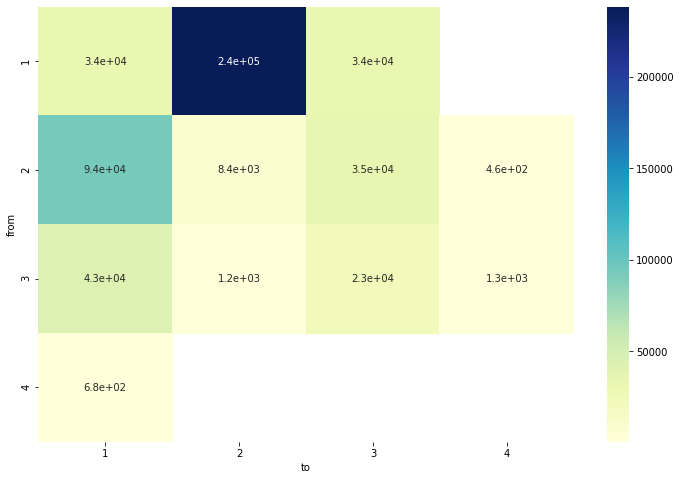

In [46]:
draw_heatmap(food_webs[0])  

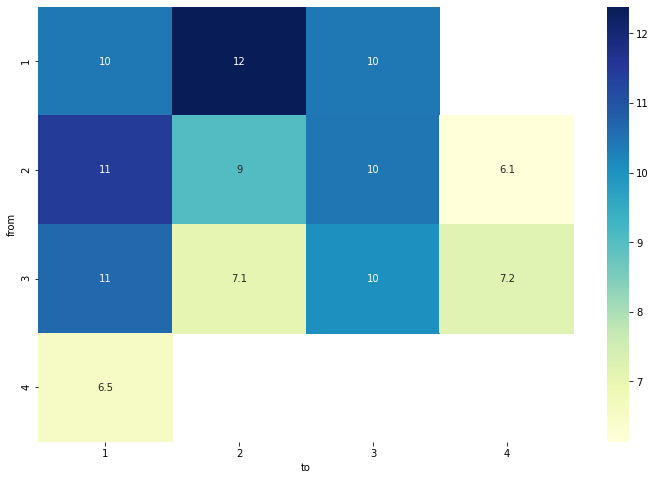

In [41]:
draw_heatmap(food_webs[0], log_scale=True)

## Fows distribution

In [47]:
def show_trophic_flows_distribution(net, normalize=False):
    tf_pd = tf_pd = get_trophic_flows(net)
    tf_pd['to'] = tf_pd['to'].astype(str)

    return alt.Chart(tf_pd).mark_bar().encode(
        x=alt.X('sum(weights):Q', stack='zero' if not normalize else 'normalize'),
        y=alt.Y('from:N'),
        color=alt.Color('to'),
        order=alt.Order(
          # Sort the segments of the bars by this field
          'to',
          sort='ascending'
        )
    ).properties(width=1320, height=400)

In [48]:
show_trophic_flows_distribution(food_webs[0])

alt.Chart(...)

In [49]:
show_trophic_flows_distribution(food_webs[0], normalize=True)

alt.Chart(...)